In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# import tensorflow
import tensorflow as tf
from tensorflow import keras

# import keras
from keras.callbacks import EarlyStopping
from tensorflow.python.keras.models import load_model
from keras.api._v2.keras import activations
from keras.engine.sequential import Sequential
from tensorflow.keras.layers import LSTM, Dense

# import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# 1. Create Data Set

## 1-1. Google Drive connect and files load

In [2]:
drive.mount('/content/drive') # 코랩에서 구글 드라이브에 마운트

Mounted at /content/drive


In [3]:
drive_path = '/content/drive/MyDrive/PNUProject/AIProject/data'
file_list = os.listdir(drive_path)
file_list

['ma.csv', 'macd.csv', 'rsi.csv', 'bb.csv', 'historydata_v1.csv']

In [4]:
df_list = []
for i in range(0,len(file_list),1):
  path = drive_path + '/' + file_list[i]
  data = pd.read_csv(path, encoding='cp949')
  path = ''
  df_list.append(data)

In [5]:
df_list[4].tail()

,open,high,low,close,volume,candel_date_time
19995,31436000.0,31497000.0,31312000.0,31469000.0,440.991947,2023-02-20 11:00:00
19996,31469000.0,31595000.0,31425000.0,31570000.0,327.507823,2023-02-20 12:00:00
19997,31570000.0,31680000.0,31554000.0,31619000.0,280.676325,2023-02-20 13:00:00
19998,31603000.0,31640000.0,31520000.0,31582000.0,219.422516,2023-02-20 14:00:00
19999,31581000.0,31647000.0,31500000.0,31583000.0,285.113594,2023-02-20 15:00:00


## 1-2. Data Preprocessing

In [6]:
# 1.보조지표 + 종가 데이터 셋 - cdf
cdf = pd.concat([df_list[4]['candel_date_time'],
                 df_list[4]['close'],
                 df_list[0]['MA_C15H'],
                 df_list[1]['MACD'],
                 df_list[2]['RSI'],
                 df_list[3]['BB+'],
                 df_list[3]['BBC'],
                 df_list[3]['BB-']], axis = 1)
# 2. 가격 데이터셋 - pdf
# Way1
df_list[4] = df_list[4][['candel_date_time','open', 'high', 'low', 'close', 'volume']]
pdf = df_list[4]
# Way2
# pdf = pd.concat([df_list[0]['candel_date_time'],
#                 df_list[0]['open'],
#                 df_list[0]['high'],
#                 df_list[0]['low'],
#                 df_list[0]['close'],
#                 df_list[0]['volume']], axis = 1)

In [8]:
pdf.tail()

,candel_date_time,open,high,low,close,volume
19995,2023-02-20 11:00:00,31436000.0,31497000.0,31312000.0,31469000.0,440.991947
19996,2023-02-20 12:00:00,31469000.0,31595000.0,31425000.0,31570000.0,327.507823
19997,2023-02-20 13:00:00,31570000.0,31680000.0,31554000.0,31619000.0,280.676325
19998,2023-02-20 14:00:00,31603000.0,31640000.0,31520000.0,31582000.0,219.422516
19999,2023-02-20 15:00:00,31581000.0,31647000.0,31500000.0,31583000.0,285.113594


In [9]:
# normalizing data
c_f_scaler = MinMaxScaler()
c_l_scaler = MinMaxScaler()
p_f_scaler = MinMaxScaler()
p_l_scaler = MinMaxScaler()

# normalizing columns setting
c_f_scale_cols = ['MA_C15H', 'MACD', 'RSI', 'BB+', 'BBC','BB-']
c_l_scale_cols = ['close']
p_f_scale_cols = ['open', 'high', 'low', 'volume']
p_l_scale_cols = ['close']

# normalizing used MinMaxScaler
c_f_scaled = c_f_scaler.fit_transform(cdf[c_f_scale_cols])
c_l_scaled = c_l_scaler.fit_transform(cdf[c_l_scale_cols])
p_f_scaled = p_f_scaler.fit_transform(pdf[p_f_scale_cols])
p_l_scaled = p_l_scaler.fit_transform(cdf[p_l_scale_cols])

# Transform to DataFrame
fcdf = pd.DataFrame(c_f_scaled, columns=c_f_scale_cols)
lcdf = pd.DataFrame(c_l_scaled, columns=c_l_scale_cols)
fpdf = pd.DataFrame(p_f_scaled, columns=p_f_scale_cols)
lpdf = pd.DataFrame(p_l_scaled, columns=p_l_scale_cols)

In [10]:
# define feature and label cols
c_feature_cols = ['MA_C15H', 'MACD', 'RSI', 'BB+', 'BBC','BB-']
c_label_col = ['close']
p_feature_cols = ['open', 'high', 'low', 'volume']
p_label_col = ['close']

# make feature and label DataFrame
c_feature_df = pd.DataFrame(fcdf, columns=c_feature_cols)
p_feature_df = pd.DataFrame(fpdf, columns=p_feature_cols)
c_label_df = pd.DataFrame(lcdf, columns=c_label_col)
p_label_df = pd.DataFrame(lpdf, columns=p_label_col)

# Transform feature and label to numpy
c_feature_np = c_feature_df.to_numpy()
p_feature_np = p_feature_df.to_numpy()
c_label_np = c_label_df.to_numpy()
p_label_np = p_label_df.to_numpy()

## 1-3. Make Sequene Dataset

In [11]:
def make_sequene_dataset(feature, label, window_size=250):
  feature_list = []
  label_list = []
  for i in range(len(feature)-window_size):
    feature_list.append(feature[i:i+window_size])
    label_list.append(label[i+window_size])
  return np.array(feature_list), np.array(label_list)

In [12]:
cX, cY = make_sequene_dataset(c_feature_np,c_label_np,250)
print(cX.shape, cY.shape,'\n')
pX, pY = make_sequene_dataset(p_feature_np,p_label_np,250)
print(pX.shape, pY.shape,'\n')

(19750, 250, 6) (19750, 1) 

(19750, 250, 4) (19750, 1) 



# 2. Make Model

## 2-1. Train and Test Data Separation

In [13]:
split = - 250
cx_train = cX[0:split]
cy_train = cY[0:split]
cx_test = cX[split:]
cy_test = cY[split:]
print(cx_train.shape, cy_train.shape)
print(cx_test.shape, cy_test.shape,'\n')
px_train = pX[0:split]
py_train = pY[0:split]
px_test = pX[split:]
py_test = pY[split:]
print(px_train.shape, py_train.shape)
print(px_test.shape, py_test.shape,'\n')

(19500, 250, 6) (19500, 1)
(250, 250, 6) (250, 1) 

(19500, 250, 4) (19500, 1)
(250, 250, 4) (250, 1) 



## 2-2. Build Up Model

In [14]:
# Build up C-Model
c_model = Sequential()
c_model.add(LSTM(128,activation='tanh',input_shape=cx_train[0].shape))
c_model.add(Dense(1, activation='linear'))
c_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69120     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 69,249
Trainable params: 69,249
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Build up P-Model
p_model = Sequential()
p_model.add(LSTM(128,activation='tanh',input_shape=px_train[0].shape))
p_model.add(Dense(1, activation='linear'))
p_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               68096     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Build up CR-Model
cr_model = Sequential()
cr_model.add(LSTM(128,activation='relu',input_shape=cx_train[0].shape))
cr_model.add(Dense(1, activation='linear'))
cr_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               69120     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,249
Trainable params: 69,249
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Build up PR-Model
pr_model = Sequential()
pr_model.add(LSTM(128,activation='relu',input_shape=px_train[0].shape))
pr_model.add(Dense(1, activation='linear'))
pr_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               68096     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Build up CTR-Model
ctr_model = Sequential()
ctr_model.add(LSTM(128,activation='tanh',input_shape=cx_train[0].shape))
ctr_model.add(Dense(64, activation='relu'))
ctr_model.add(Dense(1, activation='linear'))
ctr_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               69120     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 77,441
Trainable params: 77,441
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Build up PTR-Model
ptr_model = Sequential()
ptr_model.add(LSTM(128,activation='tanh',input_shape=px_train[0].shape))
ptr_model.add(Dense(64, activation='relu'))
ptr_model.add(Dense(1, activation='linear'))
ptr_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               68096     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 76,417
Trainable params: 76,417
Non-trainable params: 0
_________________________________________________________________


## 2-3. Training Model

### 2-3-1. C-Model

In [ ]:
c_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
c_model.fit(cx_train, cy_train, validation_data=(cx_test, cy_test), epochs=50, batch_size=64, callbacks=[early_stop])

### 2-3-2. CR-Model

In [ ]:
cr_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
cr_model.fit(cx_train, cy_train, validation_data=(cx_test, cy_test), epochs=50, batch_size=64, callbacks=[early_stop])

Epoch 1/50
305/305 [==============================] - 157s 507ms/step - loss: 0.0041 - mae: 0.0199 - val_loss: 3.1347e-05 - val_mae: 0.0044
Epoch 2/50
305/305 [==============================] - 155s 507ms/step - loss: 6.6347e-05 - mae: 0.0054 - val_loss: 1.6695e-05 - val_mae: 0.0033
Epoch 3/50
305/305 [==============================] - 157s 516ms/step - loss: 5.7738e-05 - mae: 0.0050 - val_loss: 1.2896e-05 - val_mae: 0.0023
Epoch 4/50
305/305 [==============================] - 153s 503ms/step - loss: 5.6738e-05 - mae: 0.0051 - val_loss: 1.1387e-05 - val_mae: 0.0022
Epoch 5/50
305/305 [==============================] - 160s 524ms/step - loss: 5.3093e-05 - mae: 0.0049 - val_loss: 1.3913e-05 - val_mae: 0.0024
Epoch 6/50
305/305 [==============================] - 173s 568ms/step - loss: 5.0738e-05 - mae: 0.0049 - val_loss: 1.1870e-05 - val_mae: 0.0024
Epoch 7/50
305/305 [==============================] - 172s 562ms/step - loss: 4.6098e-05 - mae: 0.0046 - val_loss: 1.2721e-05 - val_mae: 0.0

### 2-3-3. CTR-Model

In [23]:
ctr_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
ctr_model.fit(cx_train, cy_train, validation_data=(cx_test, cy_test), epochs=50, batch_size=64, callbacks=[early_stop])

Epoch 1/50
305/305 [==============================] - 96s 307ms/step - loss: 0.0026 - mae: 0.0158 - val_loss: 1.5074e-05 - val_mae: 0.0026
Epoch 2/50
305/305 [==============================] - 91s 298ms/step - loss: 7.8261e-05 - mae: 0.0058 - val_loss: 1.9817e-05 - val_mae: 0.0029
Epoch 3/50
305/305 [==============================] - 92s 303ms/step - loss: 6.5647e-05 - mae: 0.0054 - val_loss: 3.1926e-05 - val_mae: 0.0050
Epoch 4/50
305/305 [==============================] - 91s 300ms/step - loss: 6.4058e-05 - mae: 0.0054 - val_loss: 4.3010e-05 - val_mae: 0.0057
Epoch 5/50
305/305 [==============================] - 93s 306ms/step - loss: 5.6751e-05 - mae: 0.0051 - val_loss: 1.6065e-05 - val_mae: 0.0028
Epoch 6/50
305/305 [==============================] - 93s 307ms/step - loss: 5.5630e-05 - mae: 0.0051 - val_loss: 2.3482e-05 - val_mae: 0.0040


### 2-3-4. P-Model

In [ ]:
p_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
p_model.fit(px_train, py_train, validation_data=(px_test, py_test), epochs=50, batch_size=64, callbacks=[early_stop])

Epoch 1/50
305/305 [==============================] - 164s 528ms/step - loss: 0.0020 - mae: 0.0151 - val_loss: 2.2534e-05 - val_mae: 0.0028
Epoch 2/50
305/305 [==============================] - 161s 529ms/step - loss: 8.3801e-05 - mae: 0.0058 - val_loss: 2.2725e-05 - val_mae: 0.0028
Epoch 3/50
305/305 [==============================] - 153s 501ms/step - loss: 8.1570e-05 - mae: 0.0058 - val_loss: 2.1144e-05 - val_mae: 0.0031
Epoch 4/50
305/305 [==============================] - 156s 512ms/step - loss: 7.8654e-05 - mae: 0.0057 - val_loss: 2.3199e-05 - val_mae: 0.0032
Epoch 5/50
305/305 [==============================] - 162s 532ms/step - loss: 7.4998e-05 - mae: 0.0055 - val_loss: 2.1384e-05 - val_mae: 0.0034
Epoch 6/50
305/305 [==============================] - 160s 523ms/step - loss: 7.4489e-05 - mae: 0.0056 - val_loss: 2.1070e-05 - val_mae: 0.0029
Epoch 7/50
305/305 [==============================] - 164s 539ms/step - loss: 7.0009e-05 - mae: 0.0054 - val_loss: 1.6105e-05 - val_mae: 0.0

### 2-3-5. PR-Model

In [18]:
pr_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
pr_model.fit(px_train, py_train, validation_data=(px_test, py_test), epochs=50, batch_size=64, callbacks=[early_stop])

Epoch 1/50
305/305 [==============================] - 97s 310ms/step - loss: 0.0050 - mae: 0.0206 - val_loss: 3.5669e-05 - val_mae: 0.0045
Epoch 2/50
305/305 [==============================] - 93s 304ms/step - loss: 7.8247e-05 - mae: 0.0057 - val_loss: 2.0512e-05 - val_mae: 0.0026
Epoch 3/50
305/305 [==============================] - 91s 297ms/step - loss: 7.4354e-05 - mae: 0.0057 - val_loss: 2.1873e-05 - val_mae: 0.0029
Epoch 4/50
305/305 [==============================] - 94s 309ms/step - loss: 7.1175e-05 - mae: 0.0056 - val_loss: 2.0260e-05 - val_mae: 0.0033
Epoch 5/50
305/305 [==============================] - 93s 305ms/step - loss: 6.4053e-05 - mae: 0.0052 - val_loss: 4.2702e-05 - val_mae: 0.0056
Epoch 6/50
305/305 [==============================] - 95s 312ms/step - loss: 6.1326e-05 - mae: 0.0051 - val_loss: 1.5677e-05 - val_mae: 0.0027
Epoch 7/50
305/305 [==============================] - 94s 307ms/step - loss: 5.7904e-05 - mae: 0.0050 - val_loss: 1.4586e-05 - val_mae: 0.0026
Epo

### 2-3-6. PTR-Model

In [28]:
ptr_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
ptr_model.fit(px_train, py_train, validation_data=(px_test, py_test), epochs=50, batch_size=64, callbacks=[early_stop])

Epoch 1/50
305/305 [==============================] - 103s 329ms/step - loss: 0.0024 - mae: 0.0152 - val_loss: 2.3380e-05 - val_mae: 0.0028
Epoch 2/50
305/305 [==============================] - 97s 318ms/step - loss: 8.3521e-05 - mae: 0.0059 - val_loss: 2.3911e-05 - val_mae: 0.0033
Epoch 3/50
305/305 [==============================] - 95s 311ms/step - loss: 8.1777e-05 - mae: 0.0060 - val_loss: 1.8422e-05 - val_mae: 0.0028
Epoch 4/50
305/305 [==============================] - 96s 314ms/step - loss: 7.4795e-05 - mae: 0.0057 - val_loss: 1.5932e-05 - val_mae: 0.0023
Epoch 5/50
305/305 [==============================] - 96s 315ms/step - loss: 7.6656e-05 - mae: 0.0058 - val_loss: 1.4483e-05 - val_mae: 0.0022
Epoch 6/50
305/305 [==============================] - 96s 316ms/step - loss: 6.8273e-05 - mae: 0.0055 - val_loss: 2.3897e-05 - val_mae: 0.0040
Epoch 7/50
305/305 [==============================] - 97s 317ms/step - loss: 6.5837e-05 - mae: 0.0054 - val_loss: 2.1839e-05 - val_mae: 0.0035
Ep

## 2-4. Save Model


In [36]:
ctr_model.save('ctr_model.h5')
ptr_model.save('ptr_model.h5')
#pr_model.save('pr_model.h5')
#cr_model.save('cr_model.h5')
#c_model.save('c_model.h5')
#p_model.save('p_model.h5')

# 3. Predic Price

## 3-1. C-model predict price

8/8 [==============================] - 2s 252ms/step


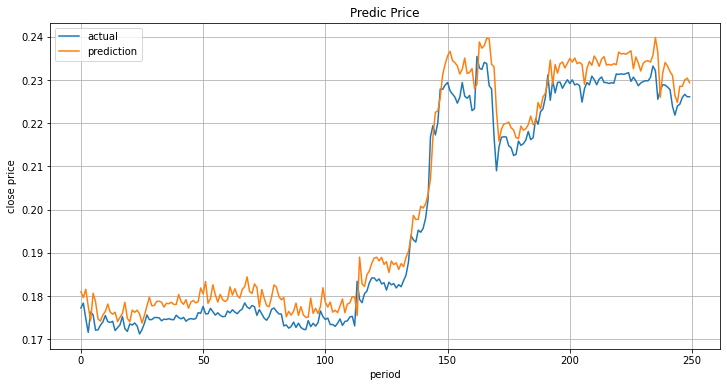

In [ ]:
# predic C-Model
c_pred = c_model.predict(cx_test)

plt.figure(figsize=(12, 6))
plt.title('Predic Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(cy_test, label='actual')
plt.plot(c_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

MSE : 98670107248.224 , RMSE : 314117.983


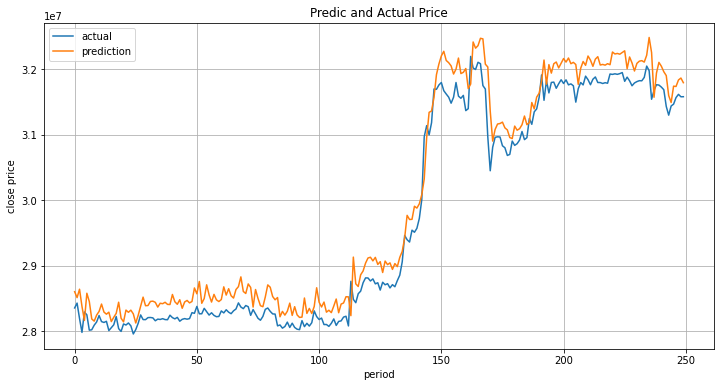

In [ ]:
# Revert normalized predic and actual data
rf_c_pred = pd.DataFrame(c_l_scaler.inverse_transform(c_pred),columns=['c_pred_close'])
rf_c_test = pd.DataFrame(c_l_scaler.inverse_transform(cy_test),columns=['actual_close'])

nc_mse = mean_squared_error(rf_c_test, rf_c_pred)
nc_rmse = np.sqrt(nc_mse)

plt.figure(figsize=(12, 6))
plt.title('Predic and Actual Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(rf_c_test, label='actual')
plt.plot(rf_c_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(nc_mse , nc_rmse))
plt.show()

## 3-2. CR-model predict price

8/8 [==============================] - 1s 75ms/step


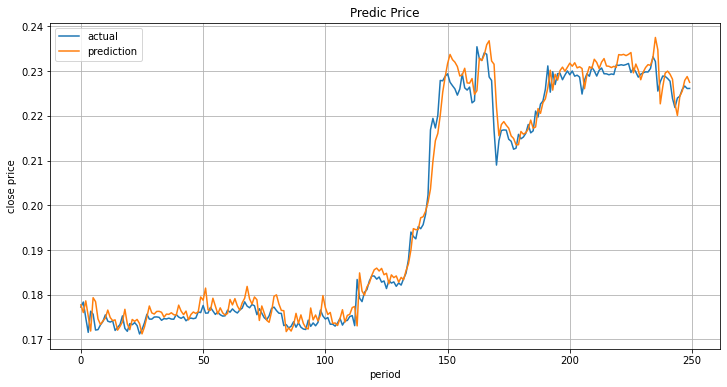

In [39]:
# predic CR-Model
cr_model = keras.models.load_model('cr_model.h5')
cr_pred = cr_model.predict(cx_test)

plt.figure(figsize=(12, 6))
plt.title('Predic Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(cy_test, label='actual')
plt.plot(cr_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

MSE : 41482405480.576 , RMSE : 203672.299


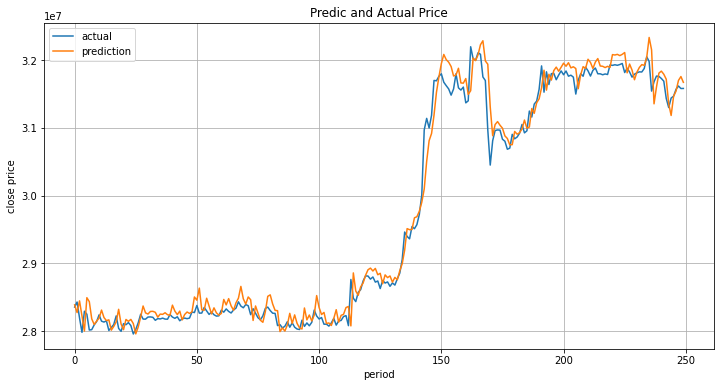

In [42]:
# Revert normalized predic and actual data
rf_cr_pred = pd.DataFrame(c_l_scaler.inverse_transform(cr_pred),columns=['tlcr_close'])
rf_cr_test = pd.DataFrame(c_l_scaler.inverse_transform(cy_test),columns=['actual_close'])

ncr_mse = mean_squared_error(rf_cr_test, rf_cr_pred)
ncr_rmse = np.sqrt(ncr_mse)

plt.figure(figsize=(12, 6))
plt.title('Predic and Actual Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(rf_cr_test, label='actual')
plt.plot(rf_cr_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(ncr_mse , ncr_rmse))
plt.show()

## 3-3. CRT-model predict price

8/8 [==============================] - 1s 76ms/step


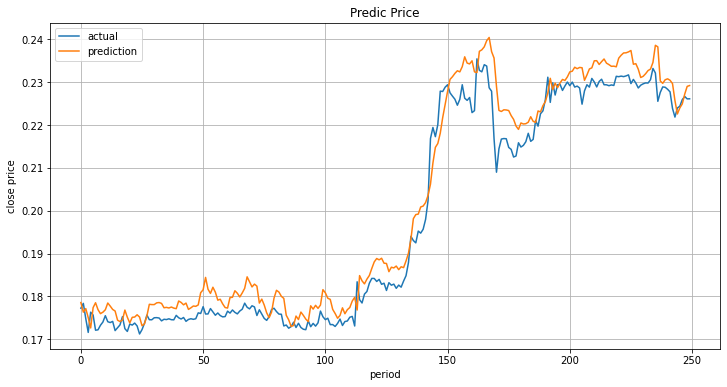

In [25]:
# predic CTR-Model
ctr_pred = ctr_model.predict(cx_test)

plt.figure(figsize=(12, 6))
plt.title('Predic Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(cy_test, label='actual')
plt.plot(ctr_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

MSE : 102448475790.784 , RMSE : 320075.734


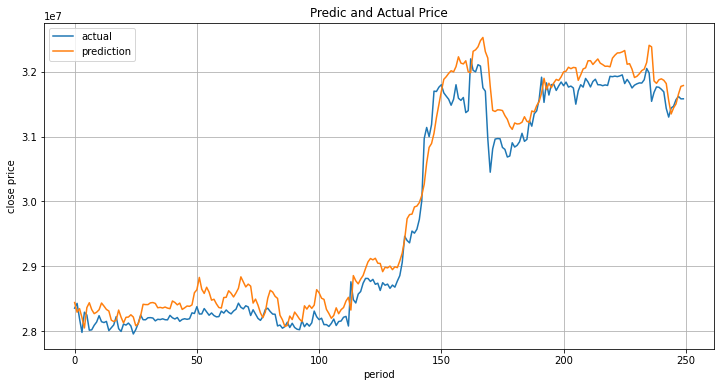

In [33]:
rf_ctr_pred = pd.DataFrame(c_l_scaler.inverse_transform(ctr_pred),columns=['tlctr_close'])
rf_ctr_test = pd.DataFrame(c_l_scaler.inverse_transform(cy_test),columns=['actual_close'])

nctr_mse = mean_squared_error(rf_ctr_test, rf_ctr_pred)
nctr_rmse = np.sqrt(nctr_mse)

plt.figure(figsize=(12, 6))
plt.title('Predic and Actual Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(rf_ctr_test, label='actual')
plt.plot(rf_ctr_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(nctr_mse , nctr_rmse))
plt.show()

## 3-4. P-model predict price

8/8 [==============================] - 1s 128ms/step


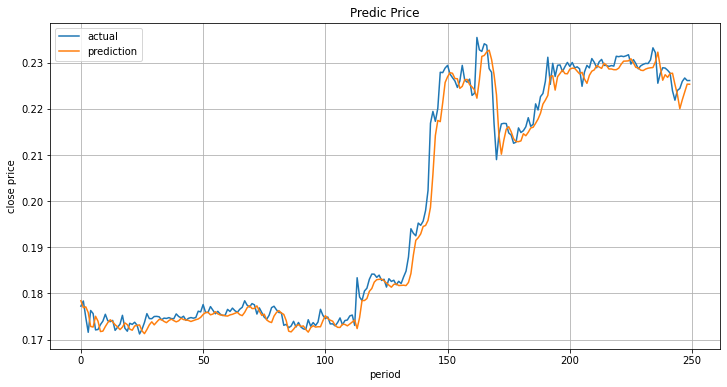

In [ ]:
# predic P-Model
p_pred = p_model.predict(px_test)

plt.figure(figsize=(12, 6))
plt.title('Predic Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(py_test, label='actual')
plt.plot(p_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

MSE : 42304581820.768 , RMSE : 205680.776


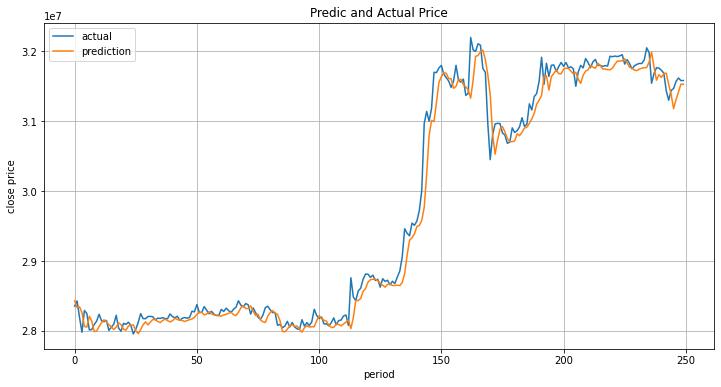

In [ ]:
# Revert normalized predic and actual data
rf_p_pred = pd.DataFrame(p_l_scaler.inverse_transform(p_pred),columns=['p_pred_close'])
rf_p_test = pd.DataFrame(p_l_scaler.inverse_transform(py_test),columns=['actual_close'])

np_mse = mean_squared_error(rf_p_test, rf_p_pred)
np_rmse = np.sqrt(np_mse)

plt.figure(figsize=(12, 6))
plt.title('Predic and Actual Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(rf_p_test, label='actual')
plt.plot(rf_p_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(np_mse , np_rmse))
plt.show()

## 3-5. PR-model predict price

8/8 [==============================] - 1s 75ms/step


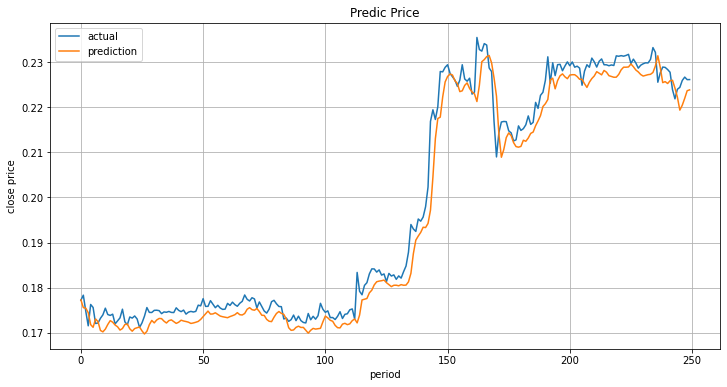

In [37]:
# predic PR-Model
pr_model = keras.models.load_model('pr_model.h5')
pr_pred = pr_model.predict(px_test)

plt.figure(figsize=(12, 6))
plt.title('Predic Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(py_test, label='actual')
plt.plot(pr_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

MSE : 63072439022.048 , RMSE : 251142.268


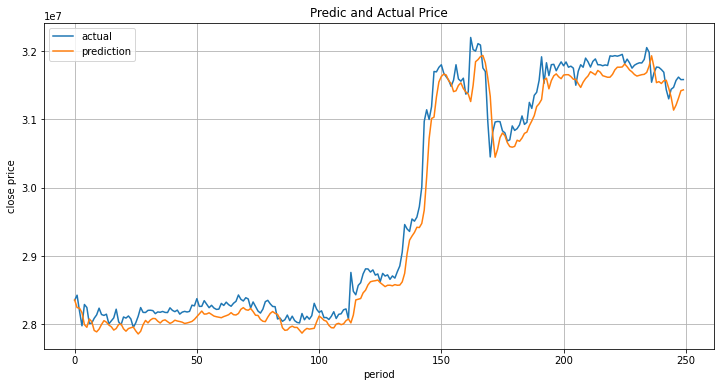

In [41]:
# Revert normalized predic and actual data
rf_pr_pred = pd.DataFrame(p_l_scaler.inverse_transform(pr_pred),columns=['tlpr_close'])
rf_pr_test = pd.DataFrame(p_l_scaler.inverse_transform(py_test),columns=['actual_close'])

npr_mse = mean_squared_error(rf_pr_test, rf_pr_pred)
npr_rmse = np.sqrt(npr_mse)

plt.figure(figsize=(12, 6))
plt.title('Predic and Actual Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(rf_pr_test, label='actual')
plt.plot(rf_pr_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(npr_mse , npr_rmse))
plt.show()

## 3-6. PTR-model predict price

8/8 [==============================] - 2s 124ms/step


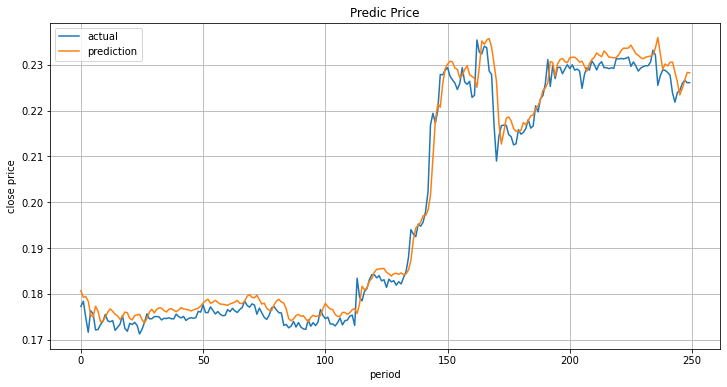

In [29]:
# predic PTR-Model
ptr_pred = ptr_model.predict(px_test)

plt.figure(figsize=(12, 6))
plt.title('Predic Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(py_test, label='actual')
plt.plot(ptr_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

MSE : 46159957835.536 , RMSE : 214848.686


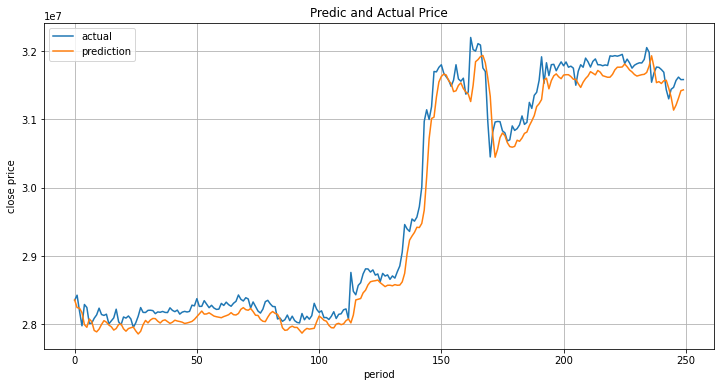

In [31]:
# Revert normalized predic and actual data
rf_ptr_pred = pd.DataFrame(p_l_scaler.inverse_transform(ptr_pred),columns=['tlptr_close'])
rf_ptr_test = pd.DataFrame(p_l_scaler.inverse_transform(py_test),columns=['actual_close'])

nptr_mse = mean_squared_error(rf_ptr_test, rf_ptr_pred)
nptr_rmse = np.sqrt(nptr_mse)

plt.figure(figsize=(12, 6))
plt.title('Predic and Actual Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(rf_pr_test, label='actual')
plt.plot(rf_pr_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(nptr_mse , nptr_rmse))
plt.show()

# 4. Save Predic Price

In [ ]:
rf_p_test.tail()

,actual_close
245,31469000.0
246,31570000.0
247,31619000.0
248,31582000.0
249,31583000.0


In [43]:
date_df = pd.DataFrame(cdf['candel_date_time'][-250:].to_numpy(), columns=['candel_date_time'])
pred_df = pd.concat([date_df['candel_date_time'],rf_pr_pred['tlpr_close'],rf_cr_pred['tlcr_close']], axis=1)
pred_df

,candel_date_time,tlpr_close,tlcr_close
0,2023-02-10 06:00:00,28360288.0,28386214.0
1,2023-02-10 07:00:00,28246102.0,28272064.0
2,2023-02-10 08:00:00,28238124.0,28444932.0
3,2023-02-10 09:00:00,28172216.0,28220940.0
4,2023-02-10 10:00:00,27997146.0,27999250.0
...,...,...,...
245,2023-02-20 11:00:00,31135968.0,31467000.0
246,2023-02-20 12:00:00,31208160.0,31544688.0
247,2023-02-20 13:00:00,31309026.0,31701510.0
248,2023-02-20 14:00:00,31419934.0,31758636.0


In [44]:
pred_df.to_csv('TL_PredictPrice_2.csv',index=False, encoding='cp949')